# Gender Classification with GoogleNet

##### Mount Google Drive

In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


##### Import All Library

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.mixed_precision.loss_scale_optimizer import optimizer
from keras import regularizers
from keras.preprocessing import image
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

#### Devine CelebA Datasets

In [ ]:
bsc_path = '/content/mount/MyDrive/Datasets/celebA'
img_path = os.path.join(bsc_path, 'images')
feature_path = os.path.join(bsc_path, 'gender_classification.csv')

In [ ]:
number_images = len(os.listdir(img_path))
print('Total Images', number_images)

Total Images 10000


In [ ]:
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(feature_path)
df.columns = ["image_id", "Gender"]
df.head()

,image_id,Gender
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0


# Exploratory Data Analysis

Melihat beberapa image yang ada pada dataset yang akan digunakan untuk membuat model

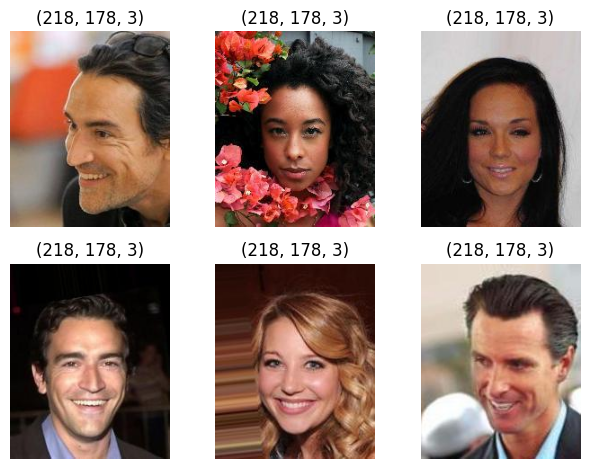

In [ ]:
# Display Multiple Sample Images.
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(img_path + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

#### Category Distribution

Melihat distribusi dari category gender

In [ ]:
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

0    5861
1    4139
Name: Gender, dtype: int64


0 = Female (Perempuan), 1 = Male (Laki-laki)

#Data Preprocessing

#### Drop Imbalance

In [ ]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

<Axes: >

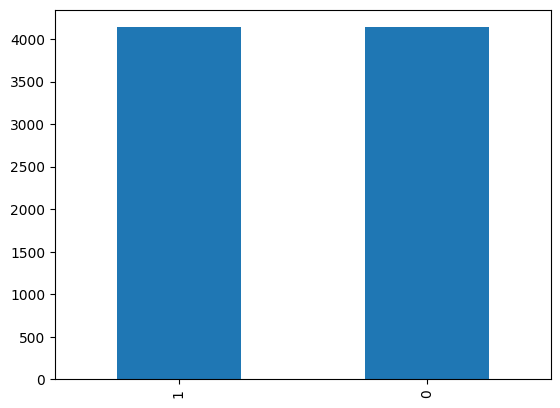

In [ ]:
df["Gender"].value_counts().plot.bar()

Berhasil menyeimbangkan data label 0 menyesuaikan dengan label 1 berjumlah 4139 setiap label nya

#### Change Label Value To String

In [ ]:
df["Gender"] = df["Gender"].map({0: "0", 1: "1"})
df.head()

,image_id,Gender
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0


# Train Test Split Data

1. Data akan dibagi menjadi beberapa ukuran training dan test size = 80:20, 70:30, 60:40
2. Diubah ukuran image nya menjadi 224 x 224

In [ ]:
train_df_82, test_df_82 = train_test_split(df, test_size=0.2)
train_df_73, test_df_73 = train_test_split(df, test_size=0.3)
train_df_64, test_df_64 = train_test_split(df, test_size=0.4)

In [ ]:
print("Total Train Sample Images 80:20 : ", len(train_df_82))
print("Total Test Sample Images 80:20 : ", len(test_df_82))
print("==========================================")
print("Total Train Sample Images 70:30 : ", len(train_df_73))
print("Total Test Sample Images 70:30 : ", len(test_df_73))
print("==========================================")
print("Total Train Sample Images 60:40 : ", len(train_df_64))
print("Total Test Sample Images 60:40 : ", len(test_df_64))

Total Train Sample Images 80:20 :  6622
Total Test Sample Images 80:20 :  1656
Total Train Sample Images 70:30 :  5794
Total Test Sample Images 70:30 :  2484
Total Train Sample Images 60:40 :  4966
Total Test Sample Images 60:40 :  3312


#### Create Image Data Generator for Train and Test Data

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range= 15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1
)
test_gen = ImageDataGenerator(rescale=1./255)

#### Split Data 80:20

In [ ]:
#train_generator 80:20
train_generator_82 = train_datagen.flow_from_dataframe(
    train_df_82, 
    img_path, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_82 = test_gen.flow_from_dataframe(
    test_df_82, 
    img_path,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 6622 validated image filenames belonging to 2 classes.
Found 1656 validated image filenames belonging to 2 classes.


#### Split Data 70:30

In [ ]:
#train_generator 70:30
train_generator_73 = train_datagen.flow_from_dataframe(
    train_df_73, 
    img_path, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_73 = test_gen.flow_from_dataframe(
    test_df_73, 
    img_path,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 5794 validated image filenames belonging to 2 classes.
Found 2484 validated image filenames belonging to 2 classes.


#### Split Data 60:40

In [ ]:
#train_generator 60:40
train_generator_64 = train_datagen.flow_from_dataframe(
    train_df_64, 
    img_path, 
    x_col='image_id',
    y_col='Gender',
    target_size=(224,224),
    class_mode='binary'
    )
test_generator_64 = test_gen.flow_from_dataframe(
    test_df_64, 
    img_path,  
    x_col='image_id',
    y_col='Gender',
    class_mode='binary',
    target_size=(224,224),
    shuffle=False
)

Found 4966 validated image filenames belonging to 2 classes.
Found 3312 validated image filenames belonging to 2 classes.


#Modelling

#### Create Model

In [ ]:
# definisikan model GoogleNet / Inception v1
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model


# Create Model untuk data split 80:20 




## Learning Rate 0.001

In [ ]:
# create model
model_82_0001 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82_0001.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_0001.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_0001 = model_82_0001.fit(train_generator_82, epochs=5, verbose = 1, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.6015
Epoch 1: val_accuracy improved from -inf to 0.73309, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_0001.h5
207/207 [==============================] - 130s 580ms/step - loss: 0.6599 - accuracy: 0.6015 - val_loss: 0.5626 - val_accuracy: 0.7331
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7085
Epoch 2: val_accuracy improved from 0.73309 to 0.75060, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_0001.h5
207/207 [==============================] - 107s 519ms/step - loss: 0.5659 - accuracy: 0.7085 - val_loss: 0.5057 - val_accuracy: 0.7506
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.7614
Epoch 3: val_accuracy improved from 0.75060 to 0.81280, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classificati

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

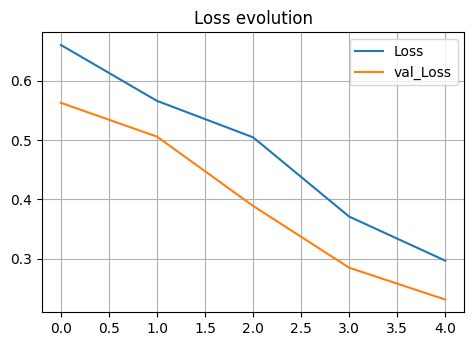

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_0001.history['loss'], label='Loss')
plt.plot(history_82_0001.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

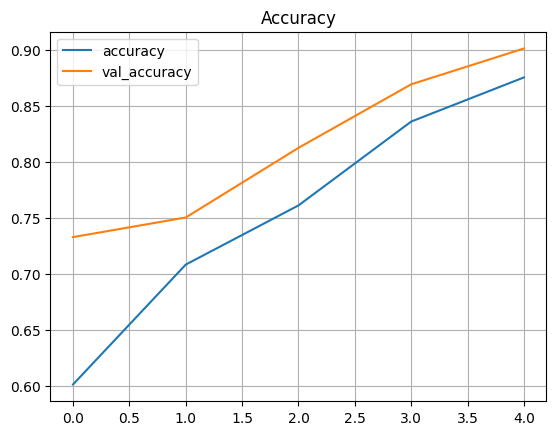

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_0001.history['accuracy'],label='accuracy')
plt.plot(history_82_0001.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_0001, test_acc_82_0001 = model_82_0001.evaluate(test_generator_82)
print('Test loss:', test_loss_82_0001)
print('Test accuracy:', test_acc_82_0001)

52/52 [==============================] - 6s 110ms/step - loss: 0.2316 - accuracy: 0.9016
Test loss: 0.23156389594078064
Test accuracy: 0.9015700221061707


In [ ]:
# Predict then save in dataframe
test_df_82.reset_index()
list_prediction_82_0001 = []
list_confidence_82_0001 = []
for index, row in test_df_82.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_82_0001 = model_82_0001.predict(x)
  confidence_82_0001 = np.max(prediction_82_0001)
  list_confidence_82_0001.append(confidence_82_0001)

  if prediction_82_0001 > 0.5:
    list_prediction_82_0001.append('1')
  else:
    list_prediction_82_0001.append('0')


test_df_82['Prediction'] = list_prediction_82_0001
test_df_82['Confidence'] = list_confidence_82_0001

1/1 [==============================] - 0s 18ms/step


In [ ]:
# Result after predict
test_df_82

,image_id,Gender,Prediction,Confidence
3196,064728.jpg,0,0,9.710097e-04
6245,127265.jpg,0,0,1.014843e-04
7809,158690.jpg,1,1,9.997024e-01
650,013246.jpg,0,0,2.019332e-02
4461,089831.jpg,0,1,9.986537e-01
...,...,...,...,...
7529,152582.jpg,1,1,9.999971e-01
5521,112046.jpg,1,1,9.999888e-01
4159,084460.jpg,0,0,2.137303e-03
4679,094792.jpg,1,1,9.998993e-01


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[750,  57],
       [332, 517]])

In [ ]:
class_labels = list(test_generator_82.class_indices.keys())

report_82_0001 = classification_report(test_df_82['Gender'].tolist(), test_df_82['Prediction'].tolist(), target_names=class_labels)
print(report_82_0001)

              precision    recall  f1-score   support

           0       0.90      0.61      0.73       849
           1       0.69      0.93      0.79       807

    accuracy                           0.77      1656
   macro avg       0.80      0.77      0.76      1656
weighted avg       0.80      0.77      0.76      1656



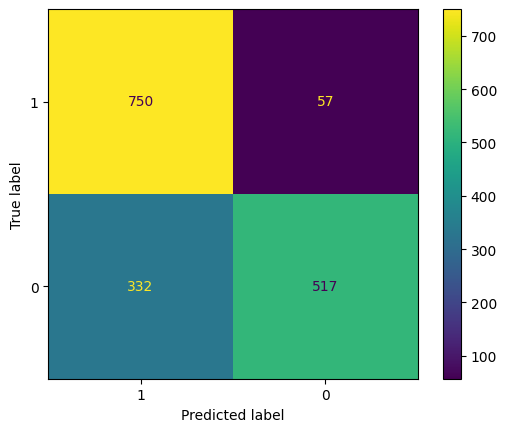

In [ ]:
disp_82_0001 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_0001.plot()
plt.show()

## Learning Rate 0.01

In [ ]:
# create model
model_82_001 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.01)
model_82_001.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_001.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_001 = model_82_001.fit(train_generator_82, epochs=5, verbose = 1, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 7.8142 - accuracy: 0.4994
Epoch 1: val_accuracy improved from -inf to 0.48732, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_001.h5
207/207 [==============================] - 105s 503ms/step - loss: 7.8142 - accuracy: 0.4994 - val_loss: 0.6937 - val_accuracy: 0.4873
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4950
Epoch 2: val_accuracy improved from 0.48732 to 0.51268, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_001.h5
207/207 [==============================] - 106s 514ms/step - loss: 0.6935 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5127
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5027
Epoch 3: val_accuracy did not improve from 0.51268
207/207 [==============================] - 109s 526ms/step - loss: 0.6933 - accuracy: 0

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

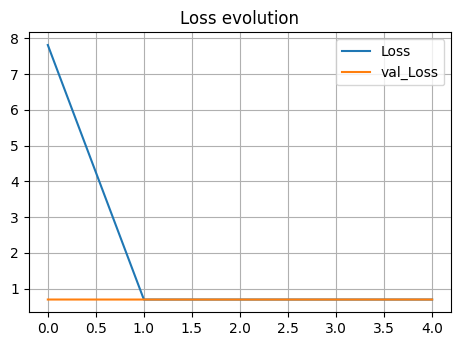

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_001.history['loss'], label='Loss')
plt.plot(history_82_001.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

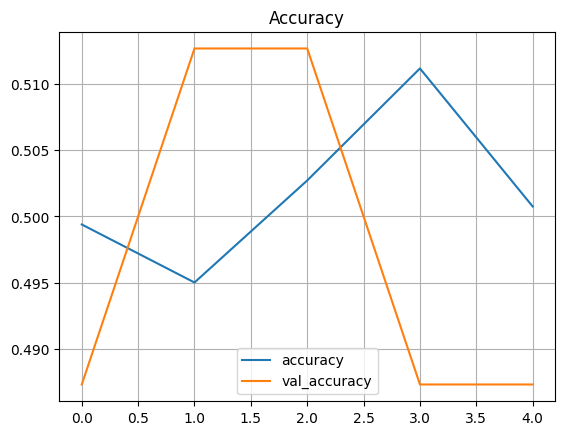

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_001.history['accuracy'],label='accuracy')
plt.plot(history_82_001.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_001, test_acc_82_001 = model_82_001.evaluate(test_generator_82)
print('Test loss:', test_loss_82_001)
print('Test accuracy:', test_acc_82_001)

52/52 [==============================] - 5s 103ms/step - loss: 0.6934 - accuracy: 0.4873
Test loss: 0.6933717131614685
Test accuracy: 0.48731884360313416


In [ ]:
# Predict then save in dataframe
test_df_82.reset_index()
list_prediction_82_001 = []
list_confidence_82_001 = []
for index, row in test_df_82.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_82_001 = model_82_001.predict(x)
  confidence_82_001 = np.max(prediction_82_001)
  list_confidence_82_001.append(confidence_82_001)

  if prediction_82_001 > 0.5:
    list_prediction_82_001.append('1')
  else:
    list_prediction_82_001.append('0')


test_df_82['Prediction'] = list_prediction_82_001
test_df_82['Confidence'] = list_confidence_82_001

1/1 [==============================] - 0s 18ms/step


In [ ]:
# Result after predict
test_df_82

,image_id,Gender,Prediction,Confidence
3196,064728.jpg,0,1,1.0
6245,127265.jpg,0,1,1.0
7809,158690.jpg,1,1,1.0
650,013246.jpg,0,1,1.0
4461,089831.jpg,0,1,1.0
...,...,...,...,...
7529,152582.jpg,1,1,1.0
5521,112046.jpg,1,1,1.0
4159,084460.jpg,0,1,1.0
4679,094792.jpg,1,1,1.0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[807,   0],
       [849,   0]])

In [ ]:
class_labels = list(test_generator_82.class_indices.keys())

report_82_001 = classification_report(test_df_82['Gender'].tolist(), test_df_82['Prediction'].tolist(), target_names=class_labels)
print(report_82_001)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       849
           1       0.49      1.00      0.66       807

    accuracy                           0.49      1656
   macro avg       0.24      0.50      0.33      1656
weighted avg       0.24      0.49      0.32      1656



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


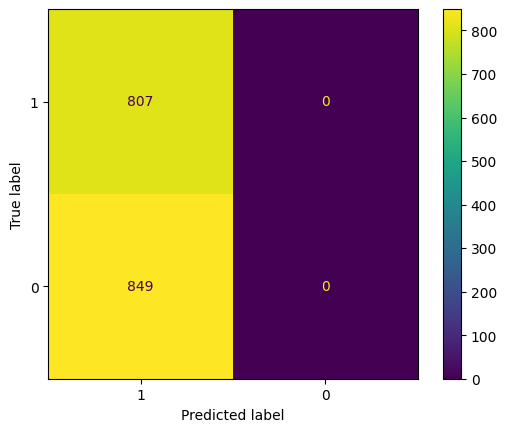

In [ ]:
disp_82_001 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_001.plot()
plt.show()

## Learning Rate 0.1

In [ ]:
# create model
model_82_01 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.1)
model_82_01.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_01.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_01 = model_82_01.fit(train_generator_82, epochs=5, verbose = 1, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 70685.1406 - accuracy: 0.5146
Epoch 1: val_accuracy improved from -inf to 0.51268, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_01.h5
207/207 [==============================] - 106s 506ms/step - loss: 70685.1406 - accuracy: 0.5146 - val_loss: 54.6748 - val_accuracy: 0.5127
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.4998
Epoch 2: val_accuracy did not improve from 0.51268
207/207 [==============================] - 109s 524ms/step - loss: 0.6957 - accuracy: 0.4998 - val_loss: 54.6738 - val_accuracy: 0.4873
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.4992
Epoch 3: val_accuracy did not improve from 0.51268
207/207 [==============================] - 105s 505ms/step - loss: 0.6947 - accuracy: 0.4992 - val_loss: 54.6727 - val_accuracy: 0.4873
Epoch 4/5
207/207 [===========================

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

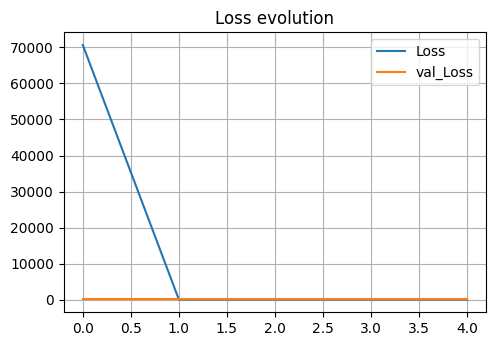

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_01.history['loss'], label='Loss')
plt.plot(history_82_01.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

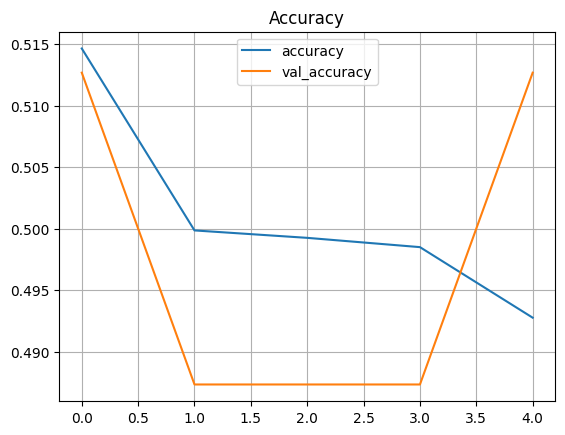

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_01.history['accuracy'],label='accuracy')
plt.plot(history_82_01.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_01, test_acc_82_01 = model_82_01.evaluate(test_generator_82)
print('Test loss:', test_loss_82_01)
print('Test accuracy:', test_acc_82_01)

52/52 [==============================] - 5s 104ms/step - loss: 54.6713 - accuracy: 0.5127
Test loss: 54.67134094238281
Test accuracy: 0.5126811861991882


In [ ]:
# Predict then save in dataframe
test_df_82.reset_index()
list_prediction_82_01 = []
list_confidence_82_01 = []
for index, row in test_df_82.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_82_01 = model_82_01.predict(x)
  confidence_82_01 = np.max(prediction_82_01)
  list_confidence_82_01.append(confidence_82_01)

  if prediction_82_01 > 0.5:
    list_prediction_82_01.append('1')
  else:
    list_prediction_82_01.append('0')


test_df_82['Prediction'] = list_prediction_82_01
test_df_82['Confidence'] = list_confidence_82_01

1/1 [==============================] - 0s 27ms/step


In [ ]:
# Result after predict
test_df_82

,image_id,Gender,Prediction,Confidence
3196,064728.jpg,0,1,1.0
6245,127265.jpg,0,1,1.0
7809,158690.jpg,1,1,1.0
650,013246.jpg,0,1,1.0
4461,089831.jpg,0,1,1.0
...,...,...,...,...
7529,152582.jpg,1,1,1.0
5521,112046.jpg,1,1,1.0
4159,084460.jpg,0,1,1.0
4679,094792.jpg,1,1,1.0


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[717,  90],
       [785,  64]])

In [ ]:
class_labels = list(test_generator_82.class_indices.keys())

report_82_01 = classification_report(test_df_82['Gender'].tolist(), test_df_82['Prediction'].tolist(), target_names=class_labels)
print(report_82_01)

              precision    recall  f1-score   support

           0       0.42      0.08      0.13       849
           1       0.48      0.89      0.62       807

    accuracy                           0.47      1656
   macro avg       0.45      0.48      0.37      1656
weighted avg       0.45      0.47      0.37      1656



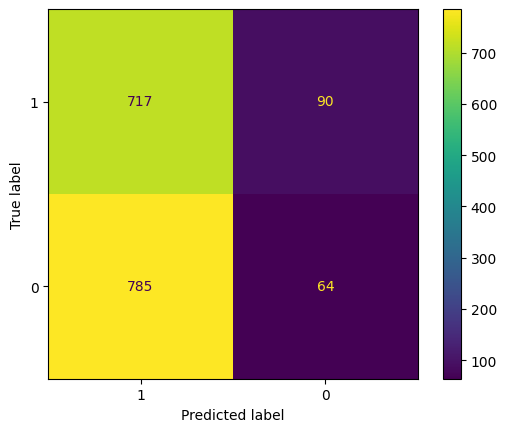

In [ ]:
disp_82_01 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_01.plot()
plt.show()

#### Kesimpulan Learning Rate
* Penggunaan learning rate nilai 0.001 lebih optimal karena nilai loss nya lebih kecil dibandingkan dengan penggunaan learning rate 0.01, 0.1

## Batch_size 16

In [ ]:
# create model
model_82_bs16 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82_bs16.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_bs16.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_bs16 = model_82_bs16.fit(train_generator_82, epochs=5, verbose = 1, batch_size=16, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.6190
Epoch 1: val_accuracy improved from -inf to 0.74094, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs16.h5
207/207 [==============================] - 106s 505ms/step - loss: 0.6487 - accuracy: 0.6190 - val_loss: 0.5415 - val_accuracy: 0.7409
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.7277
Epoch 2: val_accuracy improved from 0.74094 to 0.74940, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs16.h5
207/207 [==============================] - 112s 541ms/step - loss: 0.5498 - accuracy: 0.7277 - val_loss: 0.5212 - val_accuracy: 0.7494
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.7682
Epoch 3: val_accuracy improved from 0.74940 to 0.82126, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classificati

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

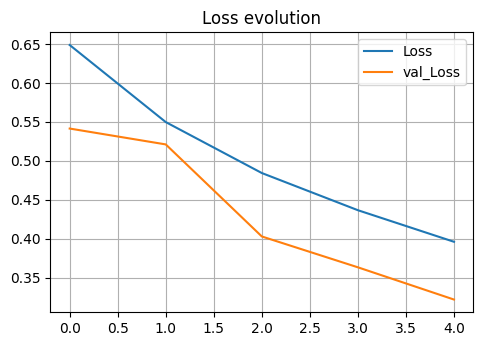

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_bs16.history['loss'], label='Loss')
plt.plot(history_82_bs16.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

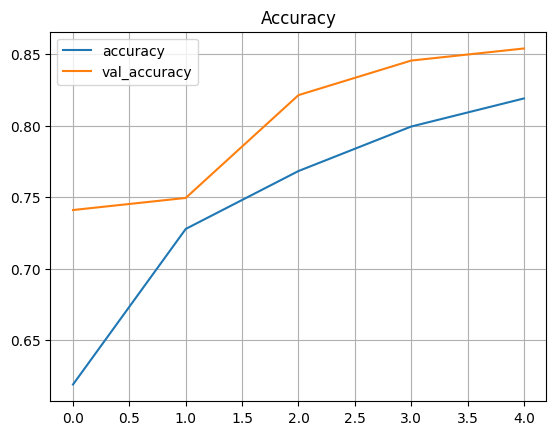

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_bs16.history['accuracy'],label='accuracy')
plt.plot(history_82_bs16.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_bs16, test_acc_82_bs16 = model_82_bs16.evaluate(test_generator_82)
print('Test loss:', test_loss_82_bs16)
print('Test accuracy:', test_acc_82_bs16)

52/52 [==============================] - 6s 112ms/step - loss: 0.3221 - accuracy: 0.8539
Test loss: 0.322123646736145
Test accuracy: 0.8538647294044495


In [ ]:
# Predict then save in dataframe
test_df_82.reset_index()
list_prediction_82_bs16 = []
list_confidence_82_bs16 = []
for index, row in test_df_82.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_82_bs16 = model_82_bs16.predict(x)
  confidence_82_bs16 = np.max(prediction_82_bs16)
  list_confidence_82_bs16.append(confidence_82_bs16)

  if prediction_82_bs16 > 0.5:
    list_prediction_82_bs16.append('1')
  else:
    list_prediction_82_bs16.append('0')


test_df_82['Prediction'] = list_prediction_82_bs16
test_df_82['Confidence'] = list_confidence_82_bs16

1/1 [==============================] - 0s 22ms/step


In [ ]:
# Result after predict
test_df_82

,image_id,Gender,Prediction,Confidence
3196,064728.jpg,0,1,0.696403
6245,127265.jpg,0,0,0.408787
7809,158690.jpg,1,1,0.634940
650,013246.jpg,0,1,0.953548
4461,089831.jpg,0,1,0.572613
...,...,...,...,...
7529,152582.jpg,1,1,0.963184
5521,112046.jpg,1,1,0.959731
4159,084460.jpg,0,1,0.693109
4679,094792.jpg,1,1,0.892732


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[698, 109],
       [552, 297]])

In [ ]:
class_labels = list(test_generator_82.class_indices.keys())

report_82_bs16 = classification_report(test_df_82['Gender'].tolist(), test_df_82['Prediction'].tolist(), target_names=class_labels)
print(report_82_bs16)

              precision    recall  f1-score   support

           0       0.73      0.35      0.47       849
           1       0.56      0.86      0.68       807

    accuracy                           0.60      1656
   macro avg       0.64      0.61      0.58      1656
weighted avg       0.65      0.60      0.57      1656



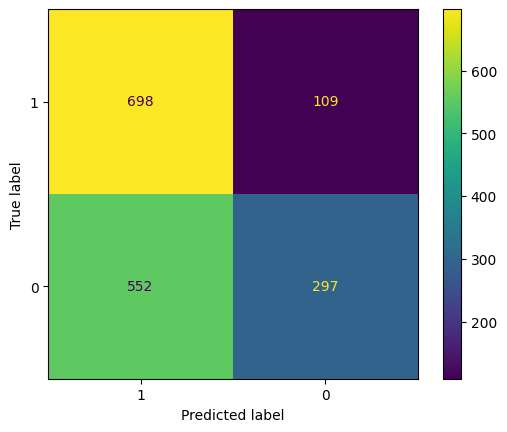

In [ ]:
disp_82_bs16 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_bs16.plot()
plt.show()

## Batch_size 32

In [ ]:
# create model
model_82_bs32 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82_bs32.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_bs32.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_bs32 = model_82_bs32.fit(train_generator_82, epochs=5, verbose = 1, batch_size=32, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.6727 - accuracy: 0.5743
Epoch 1: val_accuracy improved from -inf to 0.71498, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs32.h5
207/207 [==============================] - 104s 501ms/step - loss: 0.6727 - accuracy: 0.5743 - val_loss: 0.6170 - val_accuracy: 0.7150
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.7108
Epoch 2: val_accuracy improved from 0.71498 to 0.75121, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs32.h5
207/207 [==============================] - 103s 497ms/step - loss: 0.5711 - accuracy: 0.7108 - val_loss: 0.5261 - val_accuracy: 0.7512
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.7288
Epoch 3: val_accuracy improved from 0.75121 to 0.78804, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classificati

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

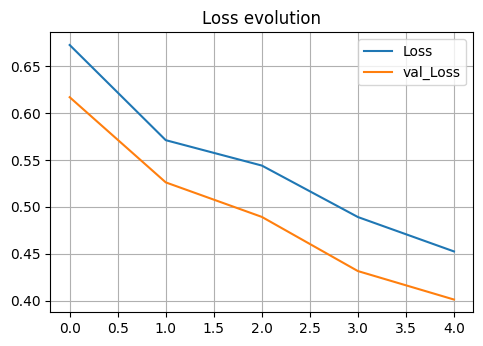

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_bs32.history['loss'], label='Loss')
plt.plot(history_82_bs32.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

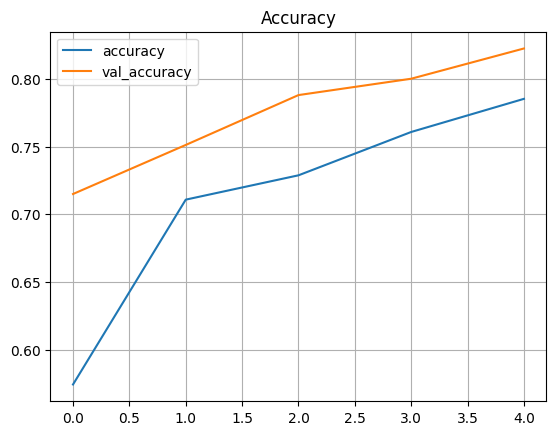

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_bs32.history['accuracy'],label='accuracy')
plt.plot(history_82_bs32.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_bs32, test_acc_82_bs32 = model_82_bs32.evaluate(test_generator_82)
print('Test loss:', test_loss_82_bs32)
print('Test accuracy:', test_acc_82_bs32)

52/52 [==============================] - 6s 111ms/step - loss: 0.4010 - accuracy: 0.8225
Test loss: 0.4010443687438965
Test accuracy: 0.8224637508392334


In [ ]:
# Predict then save in dataframe
test_df_82.reset_index()
list_prediction_82_bs32 = []
list_confidence_82_bs32 = []
for index, row in test_df_82.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_82_bs32 = model_82_bs32.predict(x)
  confidence_82_bs32 = np.max(prediction_82_bs32)
  list_confidence_82_bs32.append(confidence_82_bs32)

  if prediction_82_bs32 > 0.5:
    list_prediction_82_bs32.append('1')
  else:
    list_prediction_82_bs32.append('0')


test_df_82['Prediction'] = list_prediction_82_bs32
test_df_82['Confidence'] = list_confidence_82_bs32

1/1 [==============================] - 0s 21ms/step


In [ ]:
# Result after predict
test_df_82

,image_id,Gender,Prediction,Confidence
3196,064728.jpg,0,1,0.550415
6245,127265.jpg,0,0,0.434243
7809,158690.jpg,1,1,1.000000
650,013246.jpg,0,1,0.997839
4461,089831.jpg,0,1,0.999999
...,...,...,...,...
7529,152582.jpg,1,1,0.999476
5521,112046.jpg,1,1,1.000000
4159,084460.jpg,0,1,1.000000
4679,094792.jpg,1,1,1.000000


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[795,  12],
       [761,  88]])

In [ ]:
class_labels = list(test_generator_82.class_indices.keys())

report_82_bs32 = classification_report(test_df_82['Gender'].tolist(), test_df_82['Prediction'].tolist(), target_names=class_labels)
print(report_82_bs32)

              precision    recall  f1-score   support

           0       0.88      0.10      0.19       849
           1       0.51      0.99      0.67       807

    accuracy                           0.53      1656
   macro avg       0.70      0.54      0.43      1656
weighted avg       0.70      0.53      0.42      1656



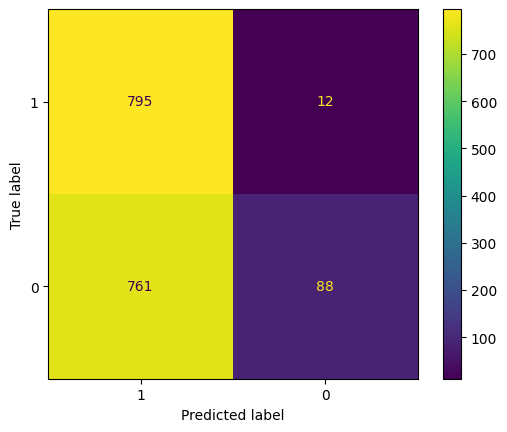

In [ ]:
disp_82_bs32 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_bs32.plot()
plt.show()

## Batch_size 64

In [ ]:
# create model
model_82_bs64 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82_bs64.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82_bs64.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82_bs64 = model_82_bs64.fit(train_generator_82, epochs=5, verbose = 1, batch_size=64, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/5
207/207 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.5719
Epoch 1: val_accuracy improved from -inf to 0.72645, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs64.h5
207/207 [==============================] - 102s 487ms/step - loss: 0.6775 - accuracy: 0.5719 - val_loss: 0.5589 - val_accuracy: 0.7264
Epoch 2/5
207/207 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7135
Epoch 2: val_accuracy improved from 0.72645 to 0.76449, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82_bs64.h5
207/207 [==============================] - 102s 493ms/step - loss: 0.5650 - accuracy: 0.7135 - val_loss: 0.4947 - val_accuracy: 0.7645
Epoch 3/5
207/207 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.7445
Epoch 3: val_accuracy improved from 0.76449 to 0.80314, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classificati

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

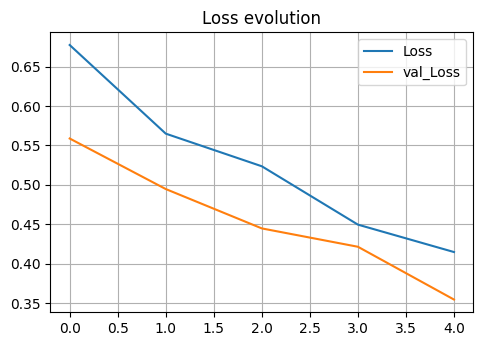

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82_bs64.history['loss'], label='Loss')
plt.plot(history_82_bs64.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

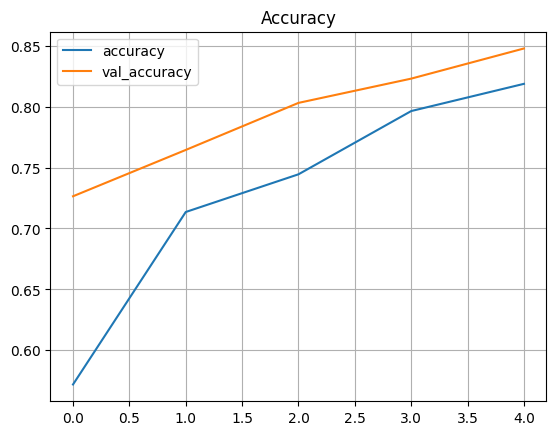

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82_bs64.history['accuracy'],label='accuracy')
plt.plot(history_82_bs64.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82_bs64, test_acc_82_bs64 = model_82_bs64.evaluate(test_generator_82)
print('Test loss:', test_loss_82_bs64)
print('Test accuracy:', test_acc_82_bs64)

52/52 [==============================] - 5s 100ms/step - loss: 0.3545 - accuracy: 0.8478
Test loss: 0.35445016622543335
Test accuracy: 0.8478260636329651


In [ ]:
# Predict then save in dataframe
test_df_82.reset_index()
list_prediction_82_bs64 = []
list_confidence_82_bs64 = []
for index, row in test_df_82.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_82_bs64 = model_82_bs64.predict(x)
  confidence_82_bs64 = np.max(prediction_82_bs64)
  list_confidence_82_bs64.append(confidence_82_bs64)

  if prediction_82_bs64 > 0.5:
    list_prediction_82_bs64.append('1')
  else:
    list_prediction_82_bs64.append('0')


test_df_82['Prediction'] = list_prediction_82_bs64
test_df_82['Confidence'] = list_confidence_82_bs64

1/1 [==============================] - 0s 31ms/step


In [ ]:
# Result after predict
test_df_82

,image_id,Gender,Prediction,Confidence
3196,064728.jpg,0,0,0.004986
6245,127265.jpg,0,1,0.577253
7809,158690.jpg,1,0,0.033530
650,013246.jpg,0,0,0.012480
4461,089831.jpg,0,0,0.200551
...,...,...,...,...
7529,152582.jpg,1,0,0.381259
5521,112046.jpg,1,1,0.996492
4159,084460.jpg,0,0,0.006365
4679,094792.jpg,1,1,0.925931


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[553, 254],
       [130, 719]])

In [ ]:
report_82_bs64 = classification_report(test_df_82['Gender'].tolist(), test_df_82['Prediction'].tolist(), target_names=class_labels)
print(report_82_bs64)

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       849
           1       0.81      0.69      0.74       807

    accuracy                           0.77      1656
   macro avg       0.77      0.77      0.77      1656
weighted avg       0.77      0.77      0.77      1656



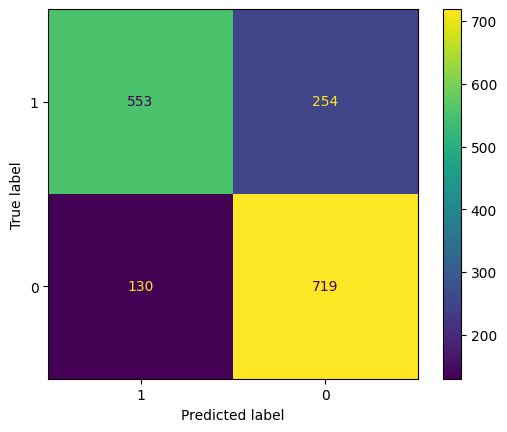

In [ ]:
disp_82_bs64 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82_bs64.plot()
plt.show()

## Split Data 80:20

In [ ]:
# create model
model_82 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_82.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_82.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_82 = model_82.fit(train_generator_82, epochs=20, verbose = 1, batch_size=16, validation_data=test_generator_82, callbacks=[checkpoint, earlystop])

Epoch 1/20
207/207 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.5959
Epoch 1: val_accuracy improved from -inf to 0.72041, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82.h5
207/207 [==============================] - 105s 503ms/step - loss: 0.6595 - accuracy: 0.5959 - val_loss: 0.5924 - val_accuracy: 0.7204
Epoch 2/20
207/207 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7303
Epoch 2: val_accuracy improved from 0.72041 to 0.78623, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_82.h5
207/207 [==============================] - 97s 470ms/step - loss: 0.5436 - accuracy: 0.7303 - val_loss: 0.4725 - val_accuracy: 0.7862
Epoch 3/20
207/207 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7741
Epoch 3: val_accuracy improved from 0.78623 to 0.81582, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

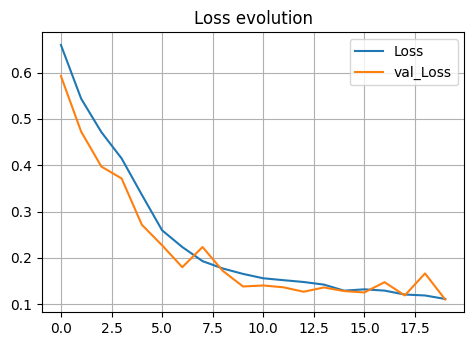

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_82.history['loss'], label='Loss')
plt.plot(history_82.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

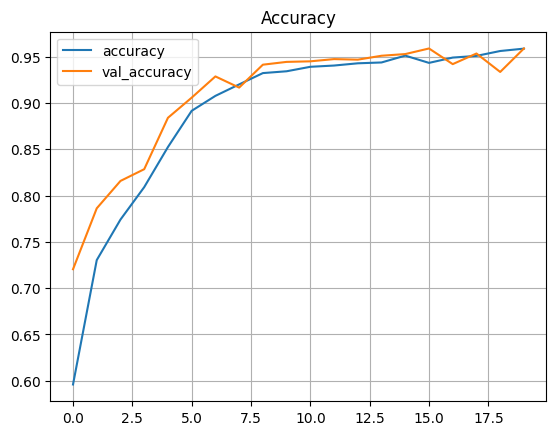

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_82.history['accuracy'],label='accuracy')
plt.plot(history_82.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_82, test_acc_82 = model_82.evaluate(test_generator_82)
print('Test loss:', test_loss_82)
print('Test accuracy:', test_acc_82)

52/52 [==============================] - 5s 93ms/step - loss: 0.1100 - accuracy: 0.9589
Test loss: 0.1099821999669075
Test accuracy: 0.9589372277259827


In [ ]:
# Predict then save in dataframe
test_df_82.reset_index()
list_prediction_82 = []
list_confidence_82 = []
for index, row in test_df_82.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_82 = model_82.predict(x)
  confidence_82 = np.max(prediction_82)
  list_confidence_82.append(confidence_82)

  if prediction_82 > 0.5:
    list_prediction_82.append('1')
  else:
    list_prediction_82.append('0')


test_df_82['Prediction'] = list_prediction_82
test_df_82['Confidence'] = list_confidence_82

1/1 [==============================] - 0s 18ms/step


In [ ]:
# Result after predict
test_df_82

,image_id,Gender,Prediction,Confidence
7267,147563.jpg,0,0,0.000010
5072,102883.jpg,0,0,0.045000
4597,093004.jpg,1,1,0.665227
3541,071917.jpg,0,0,0.000008
7676,155706.jpg,1,1,0.871980
...,...,...,...,...
6154,125496.jpg,1,1,0.980499
3463,070317.jpg,0,1,0.595860
9476,192307.jpg,1,1,0.922514
2395,048240.jpg,1,1,0.948144


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_82['Gender'], test_df_82["Prediction"], labels= labels)
cm

array([[712, 112],
       [259, 573]])

In [ ]:
class_labels = list(test_generator_82.class_indices.keys())

report_82 = classification_report(test_df_82['Gender'].tolist(), test_df_82['Prediction'].tolist(), target_names=class_labels)
print(report_82)

              precision    recall  f1-score   support

           0       0.84      0.69      0.76       832
           1       0.73      0.86      0.79       824

    accuracy                           0.78      1656
   macro avg       0.78      0.78      0.77      1656
weighted avg       0.79      0.78      0.77      1656



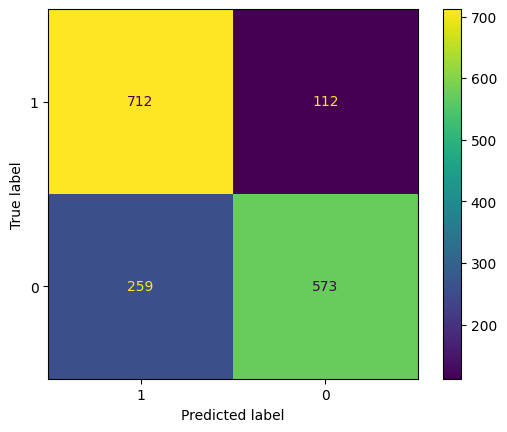

In [ ]:
disp_82 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_82.plot()
plt.show()

## Split Data 70:30

In [ ]:
# create model
model_73 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_73.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_73.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_73 = model_73.fit(train_generator_73, epochs=20, verbose = 1, batch_size=16, validation_data=test_generator_73, callbacks=[checkpoint, earlystop])

Epoch 1/20
182/182 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.6162
Epoch 1: val_accuracy improved from -inf to 0.72383, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_73.h5
182/182 [==============================] - 92s 503ms/step - loss: 0.6485 - accuracy: 0.6162 - val_loss: 0.5391 - val_accuracy: 0.7238
Epoch 2/20
182/182 [==============================] - ETA: 0s - loss: 0.5058 - accuracy: 0.7530
Epoch 2: val_accuracy improved from 0.72383 to 0.82407, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_73.h5
182/182 [==============================] - 93s 513ms/step - loss: 0.5058 - accuracy: 0.7530 - val_loss: 0.3948 - val_accuracy: 0.8241
Epoch 3/20
182/182 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.8341
Epoch 3: val_accuracy improved from 0.82407 to 0.87641, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

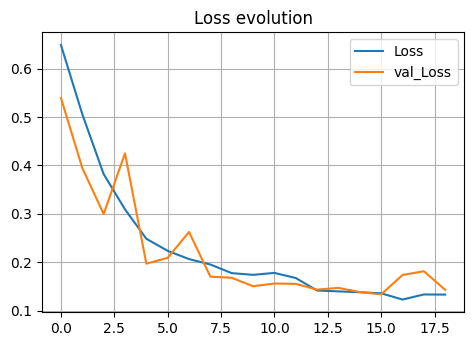

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_73.history['loss'], label='Loss')
plt.plot(history_73.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_73.history['accuracy'],label='accuracy')
plt.plot(history_73.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_73, test_acc_73 = model_73.evaluate(test_generator_73)
print('Test loss:', test_loss_73)
print('Test accuracy:', test_acc_73)

78/78 [==============================] - 8s 106ms/step - loss: 0.1430 - accuracy: 0.9452
Test loss: 0.1430288851261139
Test accuracy: 0.945249617099762


In [ ]:
# Predict then save in dataframe
test_df_73.reset_index()
list_prediction_73 = []
list_confidence_73 = []
for index, row in test_df_73.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_73 = model_73.predict(x)
  confidence_73 = np.max(prediction_73)
  list_confidence_73.append(confidence_73)

  if prediction_73 > 0.5:
    list_prediction_73.append('1')
  else:
    list_prediction_73.append('0')


test_df_73['Prediction'] = list_prediction_73
test_df_73['Confidence'] = list_confidence_73

1/1 [==============================] - 0s 19ms/step


In [ ]:
# Result after predict
test_df_73

In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_73['Gender'], test_df_73["Prediction"], labels= labels)
cm

In [ ]:
class_labels = list(test_generator_73.class_indices.keys())

report_73 = classification_report(test_df_73['Gender'].tolist(), test_df_73['Prediction'].tolist(), target_names=class_labels)
print(report_73)

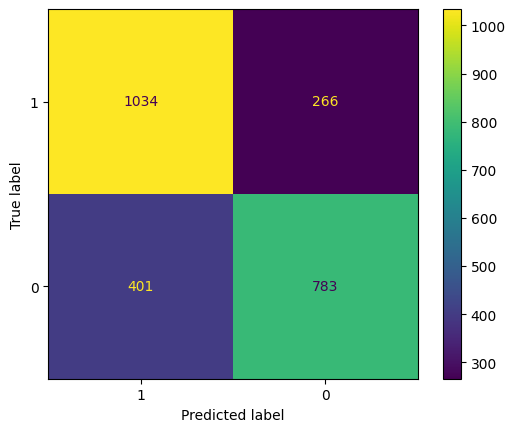

In [ ]:
disp_73 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_73.plot()
plt.show()

## Split Data 60:40

In [ ]:
# create model
model_64 = create_model()

# compile model dengan optimizer Adam
opt = Adam(lr=0.001)
model_64.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# save best model
checkpoint = ModelCheckpoint(os.path.join(bsc_path, 'Model/gender_classification_model_64.h5'), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# stop stagnant val_loss
earlystop = EarlyStopping(monitor = 'val_loss', patience=3)

# Training process
history_64 = model_64.fit(train_generator_64, epochs=20, verbose = 1, batch_size=16, validation_data=test_generator_64, callbacks=[checkpoint, earlystop])

Epoch 1/20
156/156 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.5854
Epoch 1: val_accuracy improved from -inf to 0.70833, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_64.h5
156/156 [==============================] - 188s 1s/step - loss: 0.6729 - accuracy: 0.5854 - val_loss: 0.5750 - val_accuracy: 0.7083
Epoch 2/20
156/156 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7006
Epoch 2: val_accuracy improved from 0.70833 to 0.75513, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_64.h5
156/156 [==============================] - 80s 516ms/step - loss: 0.5751 - accuracy: 0.7006 - val_loss: 0.5040 - val_accuracy: 0.7551
Epoch 3/20
156/156 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.7336
Epoch 3: val_accuracy improved from 0.75513 to 0.78925, saving model to /content/mount/MyDrive/Datasets/celebA/Model/gender_classification_model_64

#### Plotting Result Model

Text(0.5, 1.0, 'Loss evolution')

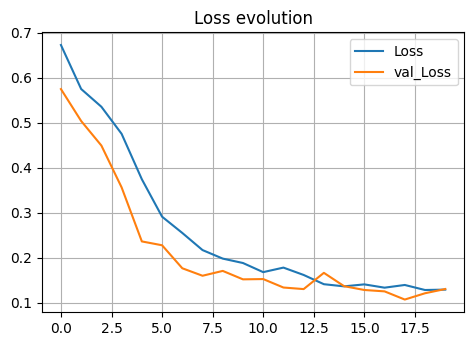

In [ ]:
# Plot result loss dan val_loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history_64.history['loss'], label='Loss')
plt.plot(history_64.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

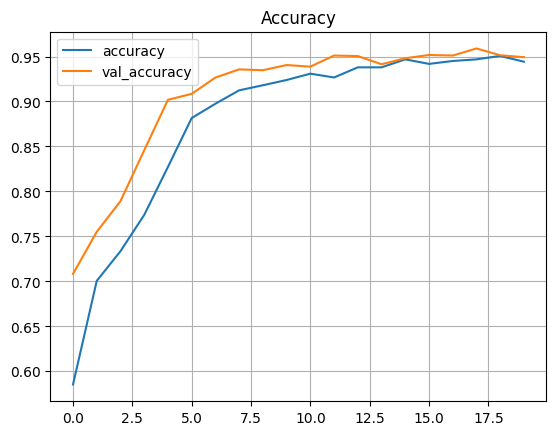

In [ ]:
# Plot result accuracy dan val_accuracy
plt.subplot(1,1,1)
plt.plot(history_64.history['accuracy'],label='accuracy')
plt.plot(history_64.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

In [ ]:
test_loss_64, test_acc_64 = model_64.evaluate(test_generator_64)
print('Test loss:', test_loss_64)
print('Test accuracy:', test_acc_64)

104/104 [==============================] - 10s 97ms/step - loss: 0.1305 - accuracy: 0.9493
Test loss: 0.1305459588766098
Test accuracy: 0.9492753744125366


In [ ]:
# Predict then save in dataframe
test_df_64.reset_index()
list_prediction_64 = []
list_confidence_64 = []
for index, row in test_df_64.iterrows():
  img_path_test = load_img(img_path +'/'+ row['image_id'], target_size = (224, 224))
  x = img_to_array(img_path_test)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  prediction_64 = model_64.predict(x)
  confidence_64 = np.max(prediction_64)
  list_confidence_64.append(confidence_64)

  if prediction_64 > 0.5:
    list_prediction_64.append('1')
  else:
    list_prediction_64.append('0')


test_df_64['Prediction'] = list_prediction_64
test_df_64['Confidence'] = list_confidence_64

1/1 [==============================] - 0s 24ms/step


In [ ]:
# Result after predict
test_df_64

,image_id,Gender,Prediction,Confidence
6863,139583.jpg,0,1,0.987443
945,018484.jpg,1,1,0.996420
4267,086303.jpg,1,1,0.988639
7964,161904.jpg,1,1,1.000000
5554,112970.jpg,0,0,0.017453
...,...,...,...,...
3982,080995.jpg,1,1,0.972228
6547,133367.jpg,1,1,0.999451
9566,194196.jpg,0,1,0.999941
1059,020870.jpg,0,1,0.948626


In [ ]:
labels = ['1','0']

cm = confusion_matrix(test_df_64['Gender'], test_df_64["Prediction"], labels= labels)
cm

array([[1664,   15],
       [1211,  422]])

In [ ]:
class_labels = list(test_generator_64.class_indices.keys())

report_64 = classification_report(test_df_64['Gender'].tolist(), test_df_64['Prediction'].tolist(), target_names=class_labels)
print(report_64)

              precision    recall  f1-score   support

           0       0.97      0.26      0.41      1633
           1       0.58      0.99      0.73      1679

    accuracy                           0.63      3312
   macro avg       0.77      0.62      0.57      3312
weighted avg       0.77      0.63      0.57      3312



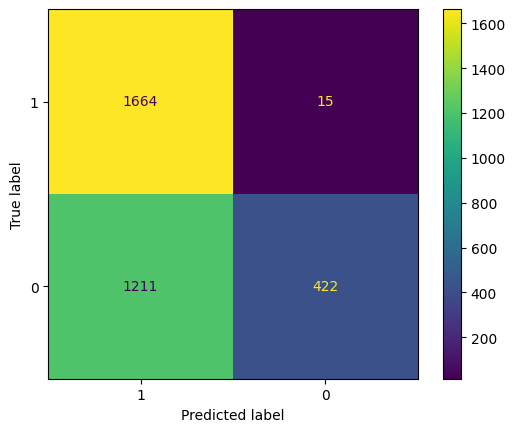

In [ ]:
disp_64 = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp_64.plot()
plt.show()